In [1]:
import torch
from torch import no_grad
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    CrossEntropyLoss
)
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchmetrics

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [3]:
torch.manual_seed(42)
batch_size = 16

# Train DataLoader
data_root = "./music/"

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
train_dataset = custom_dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_dataset))

# Test DataLoader
data_root = "./music_test/" 

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
test_dataset = custom_dataset
test_loader = DataLoader(test_dataset, shuffle=False)

print("Number of test samples:", len(test_dataset))

Number of training samples: 160
Number of test samples: 40


In [21]:
def create_qnn():
    feature_map = ZZFeatureMap(16)
    ansatz = RealAmplitudes(16, reps=5)
    qc = QuantumCircuit(16)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn = create_qnn()

In [22]:
class CNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.conv3 = Conv2d(16, 64, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(102400, 64)
        self.fc2 = Linear(64, 16)
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))     
        x = self.qnn(x)  # apply QNN 
        x= self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [23]:
model = CNN() # Model
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimizer 
loss_func = CrossEntropyLoss() # Loss Functions
epochs = 50  # Set number of epochs
loss_list = []  # Store loss history

model.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        print(loss)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

tensor(0.7904, grad_fn=<NllLossBackward0>)


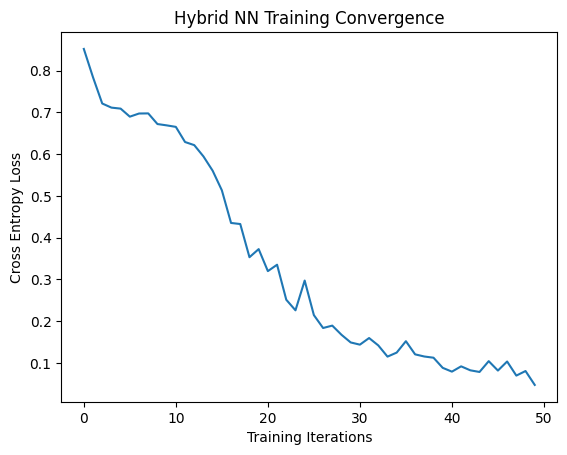

In [ ]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [ ]:
PATH = 'models/music_cnn_quantum.pt'
torch.save(model.state_dict(), PATH)

NameError: name 'torch' is not defined

In [ ]:
import torch
PATH = 'models/music_cnn_quantum.pt'
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
from torchmetrics.classification import Accuracy, ConfusionMatrix, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryHingeLoss
model.eval()

CNN(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=102400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in test_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.8999999761581421
Cross-Entropy Loss: 0.01825426146388054
Confusion Matrix:
[[16, 4], [0, 20]]
F1 Score: 0.9090909361839294
Binary Precision: 0.8333333134651184
Binary Recall: 1.0


In [ ]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in train_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.987500011920929
Cross-Entropy Loss: 0.011878984048962593
Confusion Matrix:
[[80, 0], [2, 78]]
F1 Score: 0.9873417615890503
Binary Precision: 1.0
Binary Recall: 0.9750000238418579


In [ ]:
print(loss_list)